In [1]:
import import_ipynb
from ConsistencyIndexes import *
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


### Get Original Frames

In [8]:
cap = open_vid("VDB/WID.mp4")
org = get_frames(cap)
_,_,fps,_ = get_props(cap)

Width:  640
Height:  296
FPS:  23.976023976023978
Frame Count:  133


### Get Cartoonized Frames

In [9]:
cap = open_vid("Cartoonized/WID_toon.mp4")
car = get_frames(cap)
_,_,fps,_ = get_props(cap)

Width:  640
Height:  296
FPS:  23.976
Frame Count:  133


### Calculate 2D Kernel

In [2]:
def find_2Dkernel(input_images, target_images, kernel=None, kernel_size=3, epochs=1000, lr=1e-3):  
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]    
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])       
    # Image Size
    height, width = input_images[0].shape[0], input_images[0].shape[1]      
    # Initialize the kernel
    if kernel is None:
        kernel = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)
    else:
        kh,kw = (kernel.shape[0],kernel.shape[1]) if len(kernel.shape)==2 else (kernel.shape[2],kernel.shape[3])
        kernel = torch.tensor(kernel, dtype=torch.float32).view(1, 1, kh, kw)  # Ensure it's a tensor
        kernel.requires_grad_(True)  # Set requires_grad=True for the leaf tensor 
    # Use an optimizer to update the kernel
    optimizer = torch.optim.SGD([kernel], lr=lr)        
    # List of loss over time
    L = []       
    padding = kernel.shape[2] // 2    
    # Iterate over epochs
    for epoch in range(epochs):
        total_loss = 0      
        # Iterate through each image and calculate the total loss
        for i in range(len(input_images)):
            optimizer.zero_grad()  # Clear the gradients from the previous iteration             
            # Separate each color channel
            r = input_images[i][:,:,0].view(1, 1, height, width)
            g = input_images[i][:,:,1].view(1, 1, height, width)
            b = input_images[i][:,:,2].view(1, 1, height, width)                
            # Apply convolution to each channel
            cr = F.conv2d(r, kernel, padding=padding)
            cg = F.conv2d(g, kernel, padding=padding)
            cb = F.conv2d(b, kernel, padding=padding)                
                # Calculate the loss
            loss = (F.mse_loss(cr, target_images[i][:,:,0].unsqueeze(0).unsqueeze(0)) +
                        F.mse_loss(cg, target_images[i][:,:,1].unsqueeze(0).unsqueeze(0)) +
                        F.mse_loss(cb, target_images[i][:,:,2].unsqueeze(0).unsqueeze(0)))            
            # Add to total loss
            total_loss += loss.item()
            loss.backward()  # Compute gradients        
            optimizer.step()  # Update the kernel with the computed gradients               
        # Add total loss to list over epochs
        L.append(total_loss)               
        # Print loss every epoch
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss}")
        print(kernel)
        clear_output(wait=True)
    # Return the optimized kernel and list of loss over epochs
    return kernel.detach().numpy(), L

#### Train DNN and get Kernel 

In [16]:
k,l = find_2Dkernel(org,car,epochs=2000,lr=1e-3)

Epoch 2000/2000, Total Loss: 2.113974087871611
tensor([[[[-0.0410,  0.0251,  0.0843],
          [ 0.1690,  0.5430, -0.0165],
          [ 0.0143,  0.1099,  0.0719]]]], requires_grad=True)


#### Loss Over Epochs

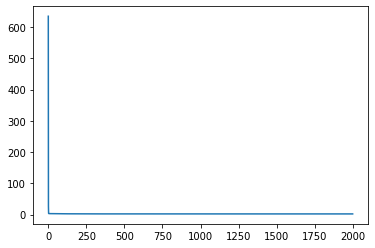

In [17]:
plt.plot(l)

### Apply Calculated Karnel to image

In [3]:
def apply_2dkernel(input_image, kernel):
    # Ensure input image is a float tensor and normalize it
    input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0
    # Convert the kernel to a PyTorch tensor if it is not already
    kh,kw = (kernel.shape[0],kernel.shape[1]) if len(kernel.shape)==2 else (kernel.shape[2],kernel.shape[3])
    kernel = torch.tensor(kernel, dtype=torch.float32).view(1, 1, kh, kw)  # Ensure it's a tensor
    # Get the dimensions of the input image
    height, width, channels = input_image.shape
    padding = kernel.shape[-1]//2
    # Ensure size of image for convolution
    r = input_image[:,:,0].view(1, 1, height, width)
    g = input_image[:,:,1].view(1, 1, height, width)
    b = input_image[:,:,2].view(1, 1, height, width)
    # Apply the kernel to each channel
    cr = F.conv2d(r, kernel, padding=padding)
    cg = F.conv2d(g, kernel, padding=padding)
    cb = F.conv2d(b, kernel, padding=padding)
    # Stack the channels back together
    output_image = torch.cat([cr, cg, cb], dim=1).squeeze(0).permute(1, 2, 0).detach().numpy()
    # Denormalize the output image (from 0-1 back to 0-255) and clip values to valid range
    output_image = (output_image * 255.0).clip(0, 255).astype('uint8')
    return output_image

### Apply Kernel to Video used in training

In [14]:
k = np.array([[-0.0410,  0.0251,  0.0843],
          [ 0.1690,  0.5430, -0.0165],
          [ 0.0143,  0.1099,  0.0719]])

In [8]:
C = [apply_2dkernel(o,k) for o in org]

In [9]:
ThroughFrames(C)

#### Differences (Black is zero difference)

In [10]:
D = [(car[i]-apply_2dkernel(org[i],k))**2 for i in range(len(car))]

In [11]:
ThroughFrames(D)

### Kernel Applied to other video

In [15]:
org1 = get_frames(open_vid("VDB/Y.mp4"))
car1 = get_frames(open_vid("Cartoonized/Ytoon.mp4"))
C1 = [apply_2dkernel(o,k) for o in org1]
D1 = [(car1[i]-apply_2dkernel(org1[i],k))**2 for i in range(len(car1))]
c1 = [cv2.filter2D(o, ddepth=-1, kernel=np.asarray(k[0][0])) for o in org1]

In [16]:
ThroughFrames(c1)

In [17]:
ThroughFrames(C1)

In [18]:
ThroughFrames(D1)

### DNN for 3D Kernel

In [4]:
def find_3Dkernel(input_images, target_images, kernel_size=3, epochs=1000, learning_rate=1e-3):
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])   
    # Image Size
    height, width = input_images[0].shape[0], input_images[0].shape[1]        
    # Initialize the kernel
    kernelr = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)  
    kernelg = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)  
    kernelb = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)  
    # Use an optimizer to update the kernel
    optimizer = torch.optim.SGD([kernelr,kernelg,kernelb], lr=learning_rate)    
    # List of loss over time
    L = []    
    padding = kernelr.shape[2] // 2 
    # Iterate over epochs
    for epoch in range(epochs):
        total_loss = 0      
        # Iterate through each image and calculate the total loss
        for i in range(len(input_images)):
            optimizer.zero_grad()  # Clear the gradients from the previous iteration  
            # Separate each color channel
            r = input_images[i][:,:,0].view(1, 1, height, width)
            g = input_images[i][:,:,1].view(1, 1, height, width)
            b = input_images[i][:,:,2].view(1, 1, height, width)            
            # Apply convolution to each channel
            cr = F.conv2d(r, kernelr, padding=padding)
            cg = F.conv2d(g, kernelg, padding=padding)
            cb = F.conv2d(b, kernelb, padding=padding)            
            # Calculate the loss
            loss = (F.mse_loss(cr, target_images[i][:,:,0].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cg, target_images[i][:,:,1].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cb, target_images[i][:,:,2].unsqueeze(0).unsqueeze(0)))            
            # Add to total loss
            total_loss += loss.item()
            loss.backward()  # Compute gradients        
            optimizer.step()  # Update the kernel with the computed gradients        
        # Add total loss to list over epochs
        L.append(total_loss)        
        # Print loss every 10 iterations
        if epoch % 1 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss}")
            print(kernelr)
            print(kernelg)
            print(kernelb)
            clear_output(wait=True)
    # Return the optimized kernel and list of loss over epochs
    return [kernelr.detach().numpy(),kernelg.detach().numpy(),kernelb.detach().numpy()], L

### Train DNN for 3D Kernel

In [26]:
k3d,l3d = find_3Dkernel(org,car,3,100,1e-3)

Epoch 100/100, Total Loss: 2.4593991488218307
tensor([[[[ 0.2747,  0.4451, -0.0337],
          [-0.2289, -0.2592,  0.4575],
          [ 0.0960, -0.2493,  0.4591]]]], requires_grad=True)
tensor([[[[ 0.0213, -0.0961,  0.0710],
          [ 0.4151, -0.2674,  0.2799],
          [ 0.2611,  0.0392,  0.2421]]]], requires_grad=True)
tensor([[[[ 0.4671, -0.0767, -0.0505],
          [-0.1127,  0.2575,  0.3471],
          [-0.2220, -0.1409,  0.4888]]]], requires_grad=True)


### Loss Over Epochs

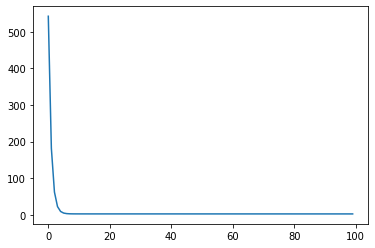

In [28]:
plt.plot(l3d)

### Apply 3D Kernel

In [12]:
def apply_3dkernel(input_image, kernel):
    # Ensure input image is a float tensor and normalize it
    input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0
    # Convert the kernel to a PyTorch tensor if it is not already
    kh,kw = (kernel[0].shape[0],kernel[0].shape[1]) if len(kernel[0].shape)==2 else (kernel[0].shape[2],kernel[0].shape[3])
    kernel = [torch.tensor(k, dtype=torch.float32).view(1, 1, kh, kw) for k in kernel]  # Ensure it's a tensor
    # Get the dimensions of the input image
    height, width, channels = input_image.shape
    # Ensure size of image for convolution
    r = input_image[:,:,0].view(1, 1, height, width)
    g = input_image[:,:,1].view(1, 1, height, width)
    b = input_image[:,:,2].view(1, 1, height, width)
    # Apply the kernel to each channel
    cr = F.conv2d(r, kernel[0], padding=1)
    cg = F.conv2d(g, kernel[1], padding=1)
    cb = F.conv2d(b, kernel[2], padding=1)
    # Stack the channels back together
    output_image = torch.cat([cr, cg, cb], dim=1).squeeze(0).permute(1, 2, 0).detach().numpy()
    # Denormalize the output image (from 0-1 back to 0-255) and clip values to valid range
    output_image = (output_image * 255.0).clip(0, 255).astype('uint8')
    return output_image

In [13]:
k3d = [np.asarray([[ 0.2747,  0.4451, -0.0337],
          [-0.2289, -0.2592,  0.4575],
          [ 0.0960, -0.2493,  0.4591]]),
      np.asarray([[ 0.0213, -0.0961,  0.0710],
          [ 0.4151, -0.2674,  0.2799],
          [ 0.2611,  0.0392,  0.2421]]),
      np.asarray([[ 0.4671, -0.0767, -0.0505],
          [-0.1127,  0.2575,  0.3471],
          [-0.2220, -0.1409,  0.4888]])]

### 3D Kernel applied to original video

In [15]:
C3d = [apply_3dkernel(o,k3d) for o in org]
ThroughFrames(C3d)

### Difference with target

In [16]:
D3d = [(car[i]-apply_3dkernel(org[i],k3d))**2 for i in range(len(car))]
ThroughFrames(D3d)

### Using another video

In [17]:
org13d = get_frames(open_vid("VDB/puppies.mp4"))
car13d = get_frames(open_vid("Cartoonized/puppiestoon.mp4"))
C13d = [apply_3dkernel(o,k3d) for o in org13d]
D13d = [(car13d[i]-apply_3dkernel(org13d[i],k3d))**2 for i in range(len(car13d))]

In [18]:
ThroughFrames(C13d)

In [19]:
ThroughFrames(D13d)

### Calculate 2D Kernel for Edge Detection

In [20]:
cap = open_vid("VDB/WID.mp4")
orgE = get_frames(cap)
w,h,fps,cnt = get_props(cap)

Width:  640
Height:  296
FPS:  23.976023976023978
Frame Count:  133


In [21]:
ed = [np.stack([canny_edge(o,0,inverted=False)]*3,axis=-1) for o in orgE]
ThroughFrames(ed)

##### Propose Starting Point

In [ ]:
#ked = np.asarray([[0,-1,0],
#                 [-1,4,-1],
#                 [0,-1,0]])
#PredE = [apply_2dkernel(o,ked) for o in orgE]
#ThroughFrames(PredE)

In [22]:
limit = 20
ked,led = find_2Dkernel(orgE[:limit],ed[:limit],epochs=100,lr=1e-3)

Epoch 100/100, Total Loss: 1.9081725608557463
tensor([[[[-0.2686, -0.1063,  0.4709],
          [-0.1697,  0.4103, -0.3849],
          [-0.1166,  0.4479, -0.1568]]]], requires_grad=True)


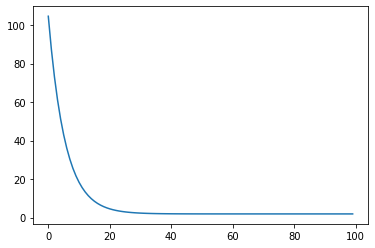

In [23]:
plt.plot(led)

In [25]:
PredE = [apply_2dkernel(o,ked) for o in orgE]
ThroughFrames(PredE)

In [26]:
PredE = [(ed[i]-apply_2dkernel(orgE[i],ked))**2 for i in range(len(ed))]
ThroughFrames(PredE)

### For another Video

In [35]:
cap = open_vid("VDB/puppies.mp4")
orgE1 = get_frames(cap)
w,h,fps,cnt = get_props(cap)

Width:  640
Height:  360
FPS:  29.97002997002997
Frame Count:  1152


In [36]:
ed1 = [np.stack([canny_edge(o,0,inverted=False)]*3,axis=-1) for o in orgE1]
ThroughFrames(ed1)

In [37]:
PredE = [apply_2dkernel(o,ked) for o in orgE1]
ThroughFrames(PredE)

In [38]:
PredE = [(ed1[i]-apply_2dkernel(orgE1[i],ked))**2 for i in range(len(ed1))]
ThroughFrames(PredE)

### Calculate 3D kernel for Edge Detection

In [20]:
cap = open_vid("VDB/WID.mp4")
orgE = get_frames(cap)
w,h,fps,cnt = get_props(cap)

Width:  640
Height:  296
FPS:  23.976023976023978
Frame Count:  133


In [21]:
ed = [np.stack([canny_edge(o,0,inverted=False)]*3,axis=-1) for o in orgE]
ThroughFrames(ed)

##### Propose Starting Point

In [ ]:
#ked = np.asarray([[0,-1,0],
#                 [-1,4,-1],
#                 [0,-1,0]])
#PredE = [apply_2dkernel(o,ked) for o in orgE]
#ThroughFrames(PredE)

In [22]:
limit = 20
ked,led = find_2Dkernel(orgE[:limit],ed[:limit],epochs=100,lr=1e-3)

Epoch 100/100, Total Loss: 1.9081725608557463
tensor([[[[-0.2686, -0.1063,  0.4709],
          [-0.1697,  0.4103, -0.3849],
          [-0.1166,  0.4479, -0.1568]]]], requires_grad=True)


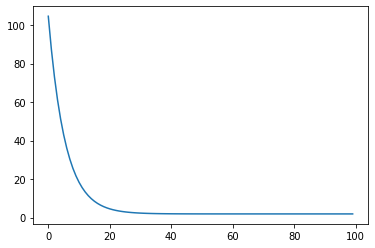

In [23]:
plt.plot(led)

In [25]:
PredE = [apply_2dkernel(o,ked) for o in orgE]
ThroughFrames(PredE)

In [26]:
PredE = [(ed[i]-apply_2dkernel(orgE[i],ked))**2 for i in range(len(ed))]
ThroughFrames(PredE)

### For another Video

In [35]:
cap = open_vid("VDB/puppies.mp4")
orgE1 = get_frames(cap)
w,h,fps,cnt = get_props(cap)

Width:  640
Height:  360
FPS:  29.97002997002997
Frame Count:  1152


In [36]:
ed1 = [np.stack([canny_edge(o,0,inverted=False)]*3,axis=-1) for o in orgE1]
ThroughFrames(ed1)

In [37]:
PredE = [apply_2dkernel(o,ked) for o in orgE1]
ThroughFrames(PredE)

In [38]:
PredE = [(ed1[i]-apply_2dkernel(orgE1[i],ked))**2 for i in range(len(ed1))]
ThroughFrames(PredE)